 # Undergraduate Project #
## Reproduce simulation results: 
### [Single-photon scattering on a qubit: Space-time structure of the scattered field](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.013519)
### Advisor: 吳致盛  &emsp; &emsp; Author: 李冠霖 [(seaotter.alex.c@nycu.edu.tw)](mailto:seaotter.alex.c@nycu.edu.tw)  
[National Yang Ming Chiao Tung University](https://www.nycu.edu.tw/), [Department of Photonics](https://dop.nycu.edu.tw/ch/index.html), [Quantum Nano-Optics Laboratory](https://jhihsheng.github.io/)


&emsp;&emsp;This Jupyter notebook briefly presents the current results of reproducing the paper's findings.

&emsp;&emsp;We are interested in the electromagnetic field generated by the interaction between photon and qubit. This research topic may have important applications in quantum devices and quantum information technology. We start from the study of the scattering field between single photon and single qubit, hoping to get the same results as the reference paper:[Single-photon scattering on a qubit: Space-time structure of the scattered field](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.107.013519)(PHYSICAL REVIEW A 107, 013519 (2023)). Below is a presentation of preliminary results.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sympy import symbols, integrate, oo, cos
from scipy.integrate import quad
import scipy.special as sc
from IPython.display import HTML
from PIL import Image
import requests
from io import BytesIO

## Basic Assumptions  
First of all, we assume that there is a single-photon Gaussian pulse of incident light interacting with a single two-level quantum in a one-dimensional waveguide, producing a reflected light and a transmitted light. As show in fig-1.

In [2]:
# FIG. 1. in PHYSICAL REVIEW A 107, 013519 (2023)
HTML("""<img src="https://journals.aps.org/pra/article/10.1103/PhysRevA.107.013519/figures/1/medium" alt="Image" width="500">""")

<div align='center'>  Fig.1 Schematic representation of a single-photon Gaussian pulse interacting with a two-level atom </div>

## Simulation 1
### &emsp; This simulation shows the intensity distribution of transmitted light and reflected light at t=1ns and t=5ns.
&emsp;&emsp; We will simulate the transmitted field at t = 1ns, and t = 5ns according to Equation 36.  
  
$ 
T(\omega_s,x,t)=T(\omega_s)e^{i\frac{\omega_s}{v_g}(x-v_gt)}$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac {iR(\omega_s)}{2\pi } e^ {i\frac {\Omega}{v_g}(x-v_gt)} e^ {\frac {\Gamma/2}{v_g}(x-v_gt)} [E_1(i\frac {x}{v_g}\tilde \Omega))+2\pi i - E_1(-i \frac {|x-v_gt|}{v_g}\tilde\Omega)]$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac{R(\omega_s)}{2\pi}$ $e^{i\frac {\omega_s}{v_g}(x-v_gt)}[ici(\omega_{s}\frac{x}{v_g})+si(\omega_s\frac{x}{v_g})-ici(\omega_s\frac{|x-v_ gt|}{v_g})+si(\omega_s\frac{|x-v_gt|}{v_g})]$  
<div align='right'>$Eq(36)$</div>  
&emsp; &emsp; &emsp;  where  &emsp; $x>0$ &emsp; $x-v_gt<0$

&emsp;&emsp; The first term in eq(36) is the transmission amplitudes from the stationary theory.
The second term describe the field generated by spontaneous emission of an excited qubit. This field dies out as the time tends to infinity.
The third term are the transmitted and reflected traveling waves which originate from the interaction of a qubit with the incident photon.

The exponential integral is defined as  
<div align='center'>$ E_1(z) = \int_{1}^{\infty}$$\frac{e^{-zt}}{t}$$dt$&emsp;&emsp;$Real(z)>0$</div>  
And the sine integral and cosine integral is defined as  
<div align='center'>$si(xy) = - \int_x^{\infty} \frac{sin(zy)}{z}dz$</div>  
<div align='center'>$ci(xy) = - \int_x^{\infty} \frac{cos(zy)}{z}dz$</div>  

After calculation, the simulation results are as follows

In [3]:
# here is the specific parameter assumptions
t1 = 10**(-9)                                           # for t=1ns
t2 = 5*(10**(-9))                                       # for t=5ns
velocity_g = 3*10**8                                    # assume group velocity of EM waves equal to that in free space, unit m/s
wavelength = 0.06                                       # wavelength of incident light, unit m
wavelength_a = 0.1*wavelength                           # simulated range of position x, start
wavelength_b = 1.1*wavelength                           # simulated range of position x, end
x_width = 100                                           # number of samples for position x
x = np.linspace(wavelength_a, wavelength_b, x_width)    # sequence of position x
Omega = 2*math.pi*5*(10**9)                             # excitation frequency of the qubit, unit GHz
Omega_a = 0.95*Omega                                    # simulated range of photon frequency omega_s, start
Omega_b = 1.05*Omega                                    # simulated range of photon frequency omega_s, end
o_width = 100                                           # number of samples for photon frequency omega_s
omega_s = np.linspace(Omega_a, Omega_b, o_width)        # sequence of photon frequency
Gamma = 2*math.pi*0.01*(10**9)                          # the rate of spontaneous emission into waveguide modes, GHz
tilde_Omega = Omega - 1j*Gamma/2                        # be used to simplify calculations

In [4]:
# Initialize the two-dimensional array used to store results
Transmission_o_x_t1 = np.array([[0+0j]*len(x)]*o_width) # Store the result when t=1ns
Transmission_o_x_t2 = np.array([[0+0j]*len(x)]*o_width) # Store the result when t=5ns
T1 = np.array([[0+0j]*len(x)]*o_width)                  # Store the results of the first part
T2 = np.array([[0.0+0.0j]*len(x)]*o_width)              # Store the results of the second part
T3 = np.array([[0+0j]*len(x)]*o_width)                  # Store the results of the third part

In [5]:
# Simulation transmission field according to eq(36)
# when t=1ns
for i in range(x_width):
    for k in range(o_width):
        
        # Set parameters to simplify calculations
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*Gamma/2/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]-velocity_g*t1
        E1a = 1j*x[i]/velocity_g*tilde_Omega
        E1b = -1j*abs(EX)/velocity_g*tilde_Omega  
        si_a = sc.sici(omega_s[k]*x[i]/velocity_g)[0] - math.pi/2
        ci_a = sc.sici(omega_s[k]*x[i]/velocity_g)[1]
        si_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[0] - math.pi/2
        ci_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t1)/velocity_g)[1]
        
        # Calculate and store the results in three parts to facilitate subsequent analysis
        T1[i][k] = Transmission_omega_s*math.e**(1j*omega_s[k]/velocity_g*EX)
        T2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*\
                   math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a))))\
                   + 2*math.pi*1j - (sc.exp1(complex(np.real(E1b), np.imag(E1b)))))
        T3[i][k] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s[k]/velocity_g*EX)*\
                   (1j*ci_a+si_a-1j*ci_b+si_b)          
        Transmission_o_x_t1[i][k] = T1[i][k] + T2[i][k] + T3[i][k] 
        
        if x[i] <= 0 :                             # Check whether formula conditions are met
            print('x<=0')
            print('x=',x[i])
            print('i=',i,'k=',k)
            break
        if EX >= 0 :
            print('x-velocity_g*t >= 0')
            break
            
# when t=5ns
for i in range(x_width):
    for k in range(o_width):
        
        # Set parameters to simplify calculations
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*Gamma/2/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]-velocity_g*t2
        E1a = 1j*x[i]/velocity_g*tilde_Omega
        E1b = -1j*abs(EX)/velocity_g*tilde_Omega
        ci_a = sc.sici(omega_s[k]*x[i]/velocity_g)[1]
        si_a = sc.sici(omega_s[k]*x[i]/velocity_g)[0] - math.pi/2
        ci_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t2)/velocity_g)[1]
        si_b = sc.sici(omega_s[k]*abs(x[i]-velocity_g*t2)/velocity_g)[0] - math.pi/2
        
        # Calculate and store the results in three parts to facilitate subsequent analysis
        T1[i][k] = Transmission_omega_s*math.e**(1j*omega_s[k]/velocity_g*EX)
        T2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*\
                   math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a))))\
                   +2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
        T3[i][k] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s[k]/velocity_g*EX)*\
                   (1j*ci_a+si_a-1j*ci_b+si_b)          
        Transmission_o_x_t2[i][k] = T1[i][k] + T2[i][k] + T3[i][k] 
        
        if x[i] <= 0 :                             # Check whether formula conditions are met
            print('x<=0')
            print('x=',x[i])
            print('i=',i,'k=',k)
            break
            break
        if EX >= 0 :
            print('x-velocity_g*t >= 0')
            break
            break

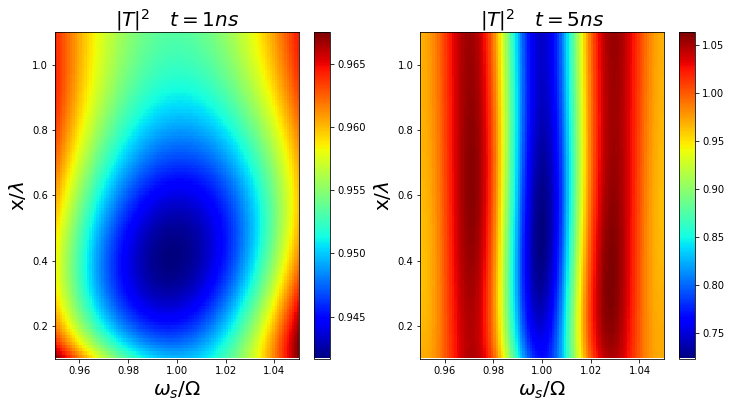

In [6]:
# Output simulation results
# t1
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(abs(Transmission_o_x_t1)**2,cmap='jet', origin='lower', 
           extent=[Omega_a/Omega, Omega_b/Omega, wavelength_a/wavelength, wavelength_b/wavelength], 
           aspect='auto')
plt.colorbar()
plt.title('$|T|^2$   $t=1ns$',fontsize=20)
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('x/$\lambda$',fontsize=20)

# t2
plt.subplot(1,2,2)
plt.imshow(abs(Transmission_o_x_t2)**2,cmap='jet', origin='lower', 
           extent=[Omega_a/Omega, Omega_b/Omega, wavelength_a/wavelength, wavelength_b/wavelength], 
           aspect='auto')
plt.colorbar()
plt.title('$|T|^2$   $t=5ns$',fontsize=20)
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('x/$\lambda$',fontsize=20)
plt.show()

<div align='center'>  Fig.2 simulation result of transmitted field </div>

&emsp;&emsp;Comparing our simulation results with those of the reference paper(as shown in below), we found that the corresponding graphics are almost identical, but the numerical values are very different.

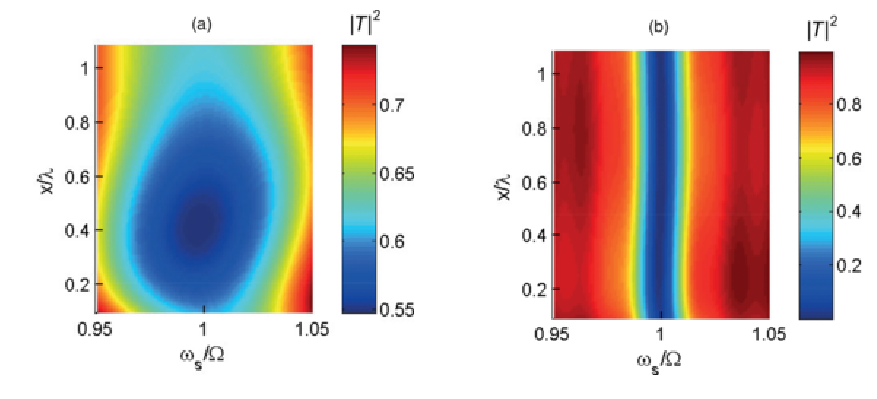

In [7]:
#Show images from paper
response = requests.get("https://journals.aps.org/pra/article/10.1103/PhysRevA.107.013519/figures/2/medium")
img = Image.open(BytesIO(response.content))
fig2_a = img.crop((0, 0, 261, 250))
fig2_b = img.crop((0, 250, 261, 500))
plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.imshow(fig2_a);
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(fig2_b);
plt.axis('off');

<div align='center'>  Fig.3 paper's transmitted field result </div>

&emsp;&emsp;Then, we perform simulations of the reflected field at t=1ns and t=5ns according to Equation 42

&emsp;&emsp;$ 
R(\omega_s,x,t)=R(\omega_s)e^{-i\frac{\omega_s}{v_g}(x+v_gt)}$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac {iR(\omega_s)}{2\pi } e^{-i\frac{\Omega}{v_g}(x+v_gt)}e^{-\frac{\Gamma/2}{v_g}(x+v_gt)} [E_1(i\frac {|x|}{v_g}\tilde \Omega)+2\pi i-E_1(-i\frac{x+v_gt}{v_g}\tilde\Omega)]$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac{R(\omega_s)}{2\pi}$ $e^{-i\frac {\omega_s}{v_g}(x+v_gt)}[ici(\omega_{s}\frac{|x|}{v_g})+si(\omega_s\frac{|x|}{v_g})-$$ici(\omega_s\frac{x+v_gt}{v_g})+si(\omega_s\frac{x+v_gt}{v_g})]$  
<div align='right'>$Eq(42)$</div>  
&emsp;&emsp;&emsp; &emsp; &emsp;  where  &emsp; $x<0$ &emsp; $x+v_gt>0$

&emsp;&emsp;Same as before, the first term in eq(42) is the reflection amplitudes from the stationary theory.
The second term describe the field generated by spontaneous emission of an excited qubit. This field dies out as the time tends to infinity.
The third term are the transmitted and reflected traveling waves which originate from the interaction of a qubit with the incident photon.

In [8]:
# Setting position x & Initialize the two-dimensional array used to store results
x = np.linspace(-wavelength_a, -wavelength_b, x_width)     # sequence of position x for reflection
Reflection_o_x_t1 = np.array([[0+0j]*len(x)]*len(omega_s)) # Store the result when t=1ns
Reflection_o_x_t2 = np.array([[0+0j]*len(x)]*len(omega_s)) # Store the result when t=5ns
R1 = np.array([[0+0j]*len(x)]*len(omega_s))                # Store the results of the first part   
R2 = np.array([[0+0j]*len(x)]*len(omega_s))                # Store the results of the second part  
R3 = np.array([[0+0j]*len(x)]*len(omega_s))                # Store the results of the third part    

In [9]:
# Simulation reflection field according to eq(42)
# when t=1ns
for i in range(len(x)):
    for k in range(len(omega_s)):
        
        # Set parameters to simplify calculations
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*(Gamma/2)/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]+velocity_g*t1
        E1a = 1j*abs(x[i])/velocity_g*tilde_Omega
        E1b = -1j*EX/velocity_g*tilde_Omega 
        si_a = sc.sici(omega_s[k]*abs(x[i])/velocity_g)[0] - math.pi/2
        ci_a = sc.sici(omega_s[k]*abs(x[i])/velocity_g)[1]
        si_b = sc.sici(omega_s[k]*(x[i]+velocity_g*t1)/velocity_g)[0] - math.pi/2
        ci_b = sc.sici(omega_s[k]*(x[i]+velocity_g*t1)/velocity_g)[1]

        # Calculate and store the results in three parts to facilitate subsequent analysis
        R1[i][k] = Reflection_omega_s*math.e**(-1j*(omega_s[k]/velocity_g)*EX)
        R2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(-1j*Omega/velocity_g*EX)*\
                   math.e**(-Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a))))\
                   + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
        R3[i][k] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s[k]/velocity_g*EX)*\
                   (1j*ci_a+si_a-1j*ci_b+si_b)
        Reflection_o_x_t1[i][k] = R1[i][k] + R2[i][k] + R3[i][k]

        if x[i] >= 0 :                             # Check whether formula conditions are met
            print('x>=0')
            print('x=',x)
            print('i=',i,'k=',k)
            break
            break
        if EX <= 0 :
            print('x+velocity_g*t1 <= 0')
            print(velocity_g*t1)
            print('i=',i,'k=',k)
            break
            break

# when t=5ns
for i in range(len(x)):
    for k in range(len(omega_s)):
        
        # Set parameters to simplify calculations
        Transmission_omega_s = (omega_s[k]-Omega)/(omega_s[k]-Omega+1j*Gamma/2)
        Reflection_omega_s = -1j*(Gamma/2)/(omega_s[k]-Omega+1j*Gamma/2)
        EX = x[i]+velocity_g*t2
        E1a = 1j*abs(x[i])/velocity_g*tilde_Omega
        E1b = -1j*EX/velocity_g*tilde_Omega 
        si_a = sc.sici(omega_s[k]*abs(x[i])/velocity_g)[0] - math.pi/2
        ci_a = sc.sici(omega_s[k]*abs(x[i])/velocity_g)[1]
        si_b = sc.sici(omega_s[k]*(x[i]+velocity_g*t2)/velocity_g)[0] - math.pi/2
        ci_b = sc.sici(omega_s[k]*(x[i]+velocity_g*t2)/velocity_g)[1] 
        
        # Calculate and store the results in three parts to facilitate subsequent analysis
        R1[i][k] = Reflection_omega_s*math.e**(-1j*(omega_s[k]/velocity_g)*EX)
        R2[i][k] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(-1j*Omega/velocity_g*EX)*\
                   math.e**(-Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a))))\
                   + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
        R3[i][k] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s[k]/velocity_g*EX)*\
                   (1j*ci_a+si_a-1j*ci_b+si_b)
        Reflection_o_x_t2[i][k] = R1[i][k] + R2[i][k] + R3[i][k]

        if x[i] >= 0 :                             # Check whether formula conditions are met
            print('x>=0')
            print('x=',x)
            print('i=',i,'k=',k)
            break
            break
        if EX <= 0 :
            print('x+velocity_g*t2 <= 0')
            print(velocity_g*t2)
            print('i=',i,'k=',k)
            break
            break

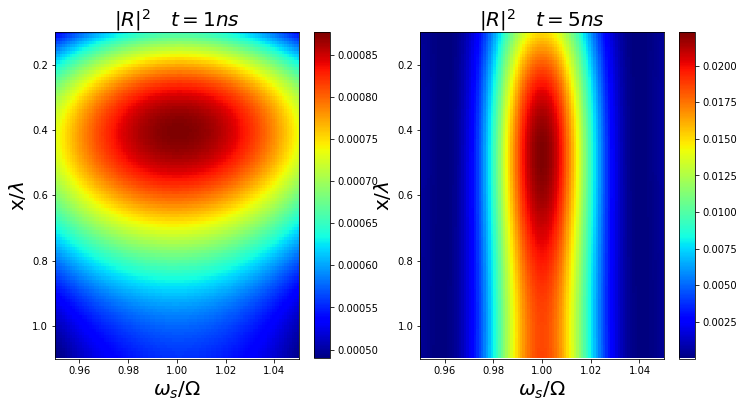

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(abs(Reflection_o_x_t1)**2,cmap='jet', origin='upper', 
           extent=[Omega_a/Omega, Omega_b/Omega, wavelength_b/wavelength, wavelength_a/wavelength], 
           aspect='auto')
plt.colorbar()
plt.title('$|R|^2$   $t=1ns$',fontsize=20)
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('x/$\lambda$',fontsize=20)

plt.subplot(1,2,2)
plt.imshow(abs(Reflection_o_x_t2)**2,cmap='jet', origin='upper',
           extent=[Omega_a/Omega, Omega_b/Omega, wavelength_b/wavelength, wavelength_a/wavelength], 
           aspect='auto')
plt.colorbar()
plt.title('$|R|^2$   $t=5ns$',fontsize=20)
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('x/$\lambda$',fontsize=20)
plt.show()

<div align='center'>  Fig.4 simulation result of reflected field </div>

&emsp;&emsp;Also comparing the results of the reflection field with the paper results (shown below), we find that the corresponding graphs are almost the same, but the values are very different.

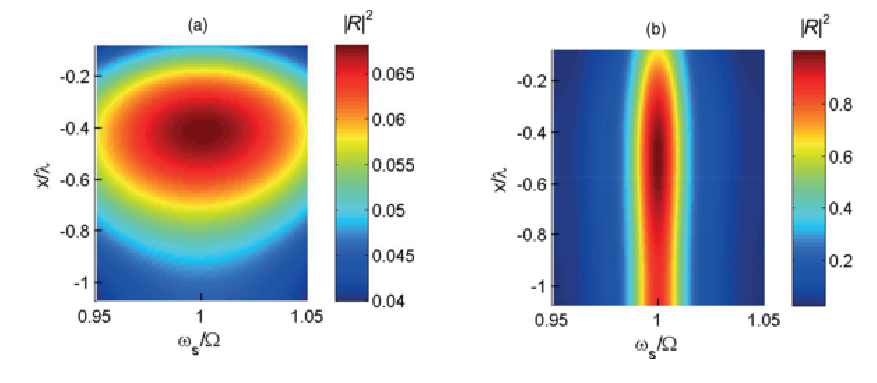

In [11]:
#Show images from paper
response = requests.get("https://journals.aps.org/pra/article/10.1103/PhysRevA.107.013519/figures/3/medium")
img = Image.open(BytesIO(response.content))
fig3_a = img.crop((0, 0, 273, 250))
fig3_b = img.crop((0, 250, 273, 500))
plt.figure(figsize=(15,7.5))
plt.subplot(1,2,1)
plt.imshow(fig3_a);
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(fig3_b);
plt.axis('off');

<div align='center'>  Fig.5 paper's reflected field result </div>

## Simulation 2
### &emsp;This simulation explores the time-varying oscillation of the transmitted and reflected fields at different incident light frequencies.

&emsp;&emsp;We draw the intensity of the transmission field and the reflection field similarly based on equations (36) and (42), with the difference being the use of time as a variable, grouped by different incident light frequencies.

In [12]:
# parameter assumptions
T_Omega = 2*math.pi/Omega                # excitation period of the qubit
t0 = 10*10**(-12)                        # simulated range of time, start
te = 1000*T_Omega                        # simulated range of time, end
xt = 0.001                               # position of transmitted field
xr = -xt                                 # position of reflection field
t_width = 100                            # number of samples for time t
t = np.linspace(t0, te, t_width)         # sequence of time t
omega_s1 = Omega                         # photon frequency 1
omega_s2 = Omega + 0.5*Gamma             # photon frequency 2
omega_s3 = Omega + 1.0*Gamma             # photon frequency 3
omega_s4 = Omega + 1.5*Gamma             # photon frequency 4

In [13]:
# Initialize arrays to store results
Transmission_o1_x_t = np.array([0+0j]*len(t))
Transmission_o2_x_t = np.array([0+0j]*len(t))
Transmission_o3_x_t = np.array([0+0j]*len(t))
Transmission_o4_x_t = np.array([0+0j]*len(t))
T1 = np.array([0+0j]*len(t))
T2 = np.array([0+0j]*len(t))
T3 = np.array([0+0j]*len(t))

Reflection_o1_x_t = np.array([0+0j]*len(t))
Reflection_o2_x_t = np.array([0+0j]*len(t))
Reflection_o3_x_t = np.array([0+0j]*len(t))
Reflection_o4_x_t = np.array([0+0j]*len(t))
R1 = np.array([0+0j]*len(t))
R2 = np.array([0+0j]*len(t))
R3 = np.array([0+0j]*len(t))

In [14]:
# according to eq(36), simulate the transmitted field in different incident frequency
# omega1
for i in range(len(t)):
    Transmission_omega_s = (omega_s1-Omega)/(omega_s1-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s1-Omega+1j*Gamma/2)
    EX = xt-velocity_g*t[i]
    E1a = 1j*xt/velocity_g*tilde_Omega
    E1b = -1j*abs(EX)/velocity_g*tilde_Omega
    si_a = sc.sici(omega_s1*xt/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s1*xt/velocity_g)[1]
    si_b = sc.sici(omega_s1*abs(xt-velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s1*abs(xt-velocity_g*t[i])/velocity_g)[1]
    # Transmission_o1_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s1/velocity_g*EX)
    T2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b)))) #exponential integral is here
    T3[i] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s1/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)           
    Transmission_o1_x_t[i] = T1[i] + T2[i] + T3[i] 
    
    if xt <= 0 :
        print('xt <= 0')
        break
    if EX >= 0 :
        print('xt-velocity_g*t >= 0')
        break
        
        
# omega2
for i in range(len(t)):
    Transmission_omega_s = (omega_s2-Omega)/(omega_s2-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s2-Omega+1j*Gamma/2)
    EX = xt-velocity_g*t[i]
    E1a = 1j*xt/velocity_g*tilde_Omega
    E1b = -1j*abs(EX)/velocity_g*tilde_Omega
    si_a = sc.sici(omega_s2*xt/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s2*xt/velocity_g)[1]
    si_b = sc.sici(omega_s2*abs(xt-velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s2*abs(xt-velocity_g*t[i])/velocity_g)[1]
    # Transmission_o2_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s2/velocity_g*EX)
    T2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b)))) #exponential integral is here
    T3[i] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s2/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)           
    Transmission_o2_x_t[i] = T1[i] + T2[i] + T3[i] 
    if xt <= 0 :
        print('xt <= 0')
        break
    if EX >= 0 :
        print('xt-velocity_g*t >= 0')
        break

# omega3
for i in range(len(t)):
    Transmission_omega_s = (omega_s3-Omega)/(omega_s3-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s3-Omega+1j*Gamma/2)
    EX = xt-velocity_g*t[i]
    E1a = 1j*xt/velocity_g*tilde_Omega
    E1b = -1j*abs(EX)/velocity_g*tilde_Omega
    si_a = sc.sici(omega_s3*xt/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s3*xt/velocity_g)[1]
    si_b = sc.sici(omega_s3*abs(xt-velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s3*abs(xt-velocity_g*t[i])/velocity_g)[1]
    # Transmission_o3_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s3/velocity_g*EX)
    T2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b)))) #exponential integral is here
    T3[i] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s3/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)           
    Transmission_o3_x_t[i] = T1[i] + T2[i] + T3[i] 
    if xt <= 0 :
        print('xt <= 0')
        break
    if EX >= 0 :
        print('xt-velocity_g*t >= 0')
        break
        
# omega4
for i in range(len(t)):
    Transmission_omega_s = (omega_s4-Omega)/(omega_s4-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s4-Omega+1j*Gamma/2)
    EX = xt-velocity_g*t[i]
    E1a = 1j*xt/velocity_g*tilde_Omega
    E1b = -1j*abs(EX)/velocity_g*tilde_Omega
    si_a = sc.sici(omega_s4*xt/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s4*xt/velocity_g)[1]
    si_b = sc.sici(omega_s4*abs(xt-velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s4*abs(xt-velocity_g*t[i])/velocity_g)[1]
    # Transmission_o4_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s4/velocity_g*EX)
    T2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*Omega/velocity_g*EX)*math.e**(Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b)))) #exponential integral is here
    T3[i] = Reflection_omega_s/2/math.pi*math.e**(1j*omega_s4/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)           
    Transmission_o4_x_t[i] = T1[i] + T2[i] + T3[i] 
    if xt <= 0 :
        print('xt <= 0')
        break
    if EX >= 0 :
        print('xt-velocity_g*t >= 0')
        break

In [15]:
# accroding to eq(42), simulate the reflected field in different incident frequency
# omega1
for i in range(len(t)):
    Transmission_omega_s = (omega_s1-Omega)/(omega_s1-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s1-Omega+1j*Gamma/2)
    EX = xr+velocity_g*t[i]    
    E1a = 1j*abs(xr)/velocity_g*tilde_Omega
    E1b = -1j*EX/velocity_g*tilde_Omega
    si_a = sc.sici(omega_s1*abs(xr)/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s1*abs(xr)/velocity_g)[1]
    si_b = sc.sici(omega_s1*(xr+velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s1*(xr+velocity_g*t[i])/velocity_g)[1]
    #Reflection_o1_x_t
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s1/velocity_g)*EX)
    R2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(-1j*Omega/velocity_g*EX)*math.e**(-Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
    R3[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s1/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)  
    Reflection_o1_x_t[i] = R1[i] + R2[i] + R3[i]

    if xr >= 0 :
        print('xr >= 0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t[i] <= 0')
        print(velocity_g*t[i])
        print('i=',i)
        break
        
# omega2
for i in range(len(t)):
    Transmission_omega_s = (omega_s2-Omega)/(omega_s2-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s2-Omega+1j*Gamma/2)
    EX = xr+velocity_g*t[i]    
    E1a = 1j*abs(xr)/velocity_g*tilde_Omega
    E1b = -1j*EX/velocity_g*tilde_Omega
    si_a = sc.sici(omega_s2*abs(xr)/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s2*abs(xr)/velocity_g)[1]
    si_b = sc.sici(omega_s2*(xr+velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s2*(xr+velocity_g*t[i])/velocity_g)[1]
    #Reflection_o1_x_t
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s2/velocity_g)*EX)
    R2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(-1j*Omega/velocity_g*EX)*math.e**(-Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
    R3[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s2/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)  
    Reflection_o2_x_t[i] = R1[i] + R2[i] + R3[i]

    if xr >= 0 :
        print('xr >= 0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t[i] <= 0')
        print(velocity_g*t[i])
        print('i=',i)
        break
# omega3
for i in range(len(t)):
    Transmission_omega_s = (omega_s3-Omega)/(omega_s3-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s3-Omega+1j*Gamma/2)
    EX = xr+velocity_g*t[i]    
    E1a = 1j*abs(xr)/velocity_g*tilde_Omega
    E1b = -1j*EX/velocity_g*tilde_Omega 
    si_a = sc.sici(omega_s3*abs(xr)/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s3*abs(xr)/velocity_g)[1]
    si_b = sc.sici(omega_s3*(xr+velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s3*(xr+velocity_g*t[i])/velocity_g)[1]
    #Reflection_o1_x_t
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s3/velocity_g)*EX)
    R2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(-1j*Omega/velocity_g*EX)*math.e**(-Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
    R3[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s3/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)  
    Reflection_o3_x_t[i] = R1[i] + R2[i] + R3[i]

    if xr >= 0 :
        print('xr >= 0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t[i] <= 0')
        print(velocity_g*t[i])
        print('i=',i)
        break
# omega4
for i in range(len(t)):
    Transmission_omega_s = (omega_s4-Omega)/(omega_s4-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s4-Omega+1j*Gamma/2)
    EX = xr+velocity_g*t[i]    
    E1a = 1j*abs(xr)/velocity_g*tilde_Omega
    E1b = -1j*EX/velocity_g*tilde_Omega
    si_a = sc.sici(omega_s4*abs(xr)/velocity_g)[0] - math.pi/2
    ci_a = sc.sici(omega_s4*abs(xr)/velocity_g)[1]
    si_b = sc.sici(omega_s4*(xr+velocity_g*t[i])/velocity_g)[0] - math.pi/2
    ci_b = sc.sici(omega_s4*(xr+velocity_g*t[i])/velocity_g)[1]
    #Reflection_o1_x_t
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s4/velocity_g)*EX)
    R2[i] = 1j*Reflection_omega_s/(2*math.pi)*math.e**(-1j*Omega/velocity_g*EX)*math.e**(-Gamma/2/velocity_g*EX)*((sc.exp1(complex(np.real(E1a), np.imag(E1a)))) + 2*math.pi*1j - sc.exp1(complex(np.real(E1b), np.imag(E1b))))
    R3[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s4/velocity_g*EX)*(1j*ci_a+si_a-1j*ci_b+si_b)  
    Reflection_o4_x_t[i] = R1[i] + R2[i] + R3[i]

    if xr >= 0 :
        print('xr >= 0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t[i] <= 0')
        print(velocity_g*t[i])
        print('i=',i)
        break

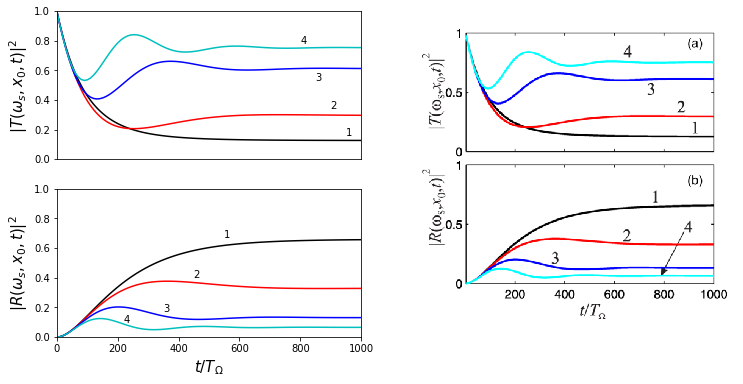

In [16]:
# Show simulation results
plt.figure(figsize=(12,6))
plt.subplot(221)
plt.plot(t,abs(Transmission_o1_x_t)**2,'k')
plt.text(0.95*te,0.16,'1')
plt.plot(t,abs(Transmission_o2_x_t)**2,'r')
plt.text(0.9*te,0.34,'2')
plt.plot(t,abs(Transmission_o3_x_t)**2,'b')
plt.text(0.85*te,0.53,'3')
plt.plot(t,abs(Transmission_o4_x_t)**2,'c')
plt.text(0.8*te,0.78,'4')
plt.ylim(0.0,1.0)
plt.xlim(0.0,te)
plt.ylabel('$|T(\omega_s,x_0,t)|^2$',fontsize=15)
plt.xticks([])
plt.subplot(223)
plt.plot(t,abs(Reflection_o1_x_t)**2,'k')
plt.text(0.55*te,0.67,'1')
plt.plot(t,abs(Reflection_o2_x_t)**2,'r')
plt.text(0.45*te,0.4,'2')
plt.plot(t,abs(Reflection_o3_x_t)**2,'b')
plt.text(0.35*te,0.17,'3')
plt.plot(t,abs(Reflection_o4_x_t)**2,'c')
plt.text(0.22*te,0.1,'4')
plt.ylim(0.0,1.0)
plt.xlim(0.0,te)
plt.xticks([te*0,te*0.2,te*0.4,te*0.6,te*0.8,te*1],[0,200,400,600,800,1000])
plt.ylabel('$|R(\omega_s,x_0,t)|^2$',fontsize=15)
plt.xlabel('$t/T_\Omega$',fontsize=15)

# Show images from paper
response = requests.get("https://journals.aps.org/pra/article/10.1103/PhysRevA.107.013519/figures/4/medium")
img = Image.open(BytesIO(response.content))
fig4 = img.crop((0, 0, 500, 476))
plt.subplot2grid((2,2), (0, 1), rowspan=2, colspan=1)
plt.imshow(fig4);
plt.axis('off');

<div align='center'>  Fig.6 the time-varying oscillation of fields,simulation(left), paper(right) </div>

&emsp;&emsp;$(1)\omega_s = \Omega $&emsp;$(2)\omega_s = \Omega + 0.5\Gamma$ &emsp;$(3)\omega_s = \Omega +\Gamma$ &emsp;$(4)\omega_s = \Omega + 1.5\Gamma$  
&emsp;&emsp;where $\omega_s$ is the incident light frequency  
&emsp;&emsp;&emsp;&emsp;&emsp;$\Omega$ is the qubit excitation frequency  
&emsp;&emsp;&emsp;&emsp;&emsp;$\Gamma$ is the rate of spontaneous emission into waveguide modes

&emsp; We can see that the simulated results (left) match the results in the paper. The oscillation phenomenon becomes more pronounced as the incident light frequency moves further away from the qubit excitation frequency.

## Simulation 3: The scattered field at large time
#### &emsp; Now we are going to search how the scattered field [second terms in (43) and (44)] influences the amplitude-frequency curves (AFCs) of transmitted and reflected signals. 
&emsp; In the case of large time, equations (36) and (42) can be simplified to equations (43) and (44).  
&emsp; The dependence of AFCs on the distance from the qubit is shown in below

$ 
T(\omega_s,x,t)=T(\omega_s)e^{i\frac{\omega_s}{v_g}(x-v_gt)}$  
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$-i\frac{R(\omega_s)}{2\pi}$ $e^{i\frac {\omega_s}{v_g}(x-v_gt)}[ici(\omega_{s}\frac{x}{v_g})+si(\omega_s\frac{x}{v_g})]$  
$Eq(43)$  
&emsp; &emsp; &emsp; &emsp; $x>0$ &emsp; $x-v_gt<0$

$ 
R(\omega_s,x,t)=R(\omega_s)e^{-i\frac{\omega_s}{v_g}(x+v_gt)}$   
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac{R(\omega_s)}{2\pi}$ $e^{-i\frac {\omega_s}{v_g}(x+v_gt)}[ici(\omega_{s}\frac{|x|}{v_g})+si(\omega_s\frac{|x|}{v_g})]$  
$Eq(44)$  
&emsp; &emsp; &emsp; &emsp; $x<0$ &emsp; $x+v_gt>0$

In [17]:
t = 10**(-9) #1ns 自訂
x1 = 0.001 #1mm
x2 = 0.005 #5mm
x3 = 0.010 #10mm
o_width = 100
omega_sa = 0.995*Omega
omega_sb = 1.005*Omega
omega_s = np.linspace(omega_sa, omega_sb, o_width)

In [18]:
Transmission_o_x1_t = np.array([0+0j]*len(omega_s))
Transmission_o_x2_t = np.array([0+0j]*len(omega_s))
Transmission_o_x3_t = np.array([0+0j]*len(omega_s))
T0 = np.array([0+0j]*len(omega_s))
T1 = np.array([0+0j]*len(omega_s))
T2 = np.array([0+0j]*len(omega_s))
T3 = np.array([0+0j]*len(omega_s))

Reflection_o_x1_t = np.array([0+0j]*len(omega_s))
Reflection_o_x2_t = np.array([0+0j]*len(omega_s))
Reflection_o_x3_t = np.array([0+0j]*len(omega_s))
R0 = np.array([0+0j]*len(omega_s))
R1 = np.array([0+0j]*len(omega_s))
R2 = np.array([0+0j]*len(omega_s))
R3 = np.array([0+0j]*len(omega_s))

In [19]:
# x1
# 公式43 #
for i in range(len(omega_s)):
    Transmission_omega_s = (omega_s[i]-Omega)/(omega_s[i]-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s[i]-Omega+1j*Gamma/2)
    EX = x1-velocity_g*t
    ci = sc.sici(omega_s[i]*x1/velocity_g)[1]
    si = sc.sici(omega_s[i]*x1/velocity_g)[0] - math.pi/2
    # Transmission_o_x1_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s[i]/velocity_g*EX)
    T2[i] = -1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*omega_s[i]/velocity_g*EX)
    T3[i] = 1j*ci+si          
    Transmission_o_x1_t[i] = T1[i] + T2[i] * T3[i]

    if x1 <= 0 :
        print('x1<=0')
        break
    if EX >= 0 :
        print('x1-velocity_g*t >= 0')
        break
        
T1 = np.array([0+0j]*len(omega_s))
T2 = np.array([0+0j]*len(omega_s))
T3 = np.array([0+0j]*len(omega_s))  
            
# x2
# 公式43 #
for i in range(len(omega_s)):
    Transmission_omega_s = (omega_s[i]-Omega)/(omega_s[i]-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s[i]-Omega+1j*Gamma/2)
    EX = x2-velocity_g*t
    ci = sc.sici(omega_s[i]*x2/velocity_g)[1]
    si = sc.sici(omega_s[i]*x2/velocity_g)[0] - math.pi/2
    # Transmission_o_x2_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s[i]/velocity_g*EX)
    T2[i] = -1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*omega_s[i]/velocity_g*EX)
    T3[i] = 1j*ci+si 
    Transmission_o_x2_t[i] = T1[i] + T2[i] * T3[i]

    if x2 <= 0 :
        print('x2<=0')
        break
    if EX >= 0 :
        print('x2-velocity_g*t >= 0')
        break

T1 = np.array([0+0j]*len(omega_s))
T2 = np.array([0+0j]*len(omega_s))
T3 = np.array([0+0j]*len(omega_s))

# x3
# 公式43 #
for i in range(len(omega_s)):
    Transmission_omega_s = (omega_s[i]-Omega)/(omega_s[i]-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s[i]-Omega+1j*Gamma/2)
    EX = x3-velocity_g*t
    ci = sc.sici(omega_s[i]*x3/velocity_g)[1]
    si = sc.sici(omega_s[i]*x3/velocity_g)[0] - math.pi/2
    # Transmission_o_x3_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s[i]/velocity_g*EX)
    T2[i] = -1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*omega_s[i]/velocity_g*EX)
    T3[i] = 1j*ci+si 
    Transmission_o_x3_t[i] = T1[i] + T2[i] * T3[i]

    if x3 <= 0 :
        print('x3<=0')
        break
    if EX >= 0 :
        print('x3-velocity_g*t >= 0')
        break
        
T1 = np.array([0+0j]*len(omega_s))
T2 = np.array([0+0j]*len(omega_s))
T3 = np.array([0+0j]*len(omega_s))

In [20]:
# -x1
# 公式44 #
for i in range(len(omega_s)):
    Transmission_omega_s = (omega_s[i]-Omega)/(omega_s[i]-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s[i]-Omega+1j*Gamma/2)
    EX = -x1+velocity_g*t
    ci = sc.sici(omega_s[i]*abs(-x1)/velocity_g)[1]
    si = sc.sici(omega_s[i]*abs(-x1)/velocity_g)[0] - math.pi/2
    # Reflection_o_x1_t
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s[i]/velocity_g)*EX)
    R2[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s[i]/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o_x1_t[i] = R1[i] + R2[i] * R3[i] 
    if -x1 >= 0 :
        print('-x1>=0')
        break
    if EX <= 0 :
        print('x1+velocity_g*t <= 0')
        break
R1 = np.array([0+0j]*len(omega_s))
R2 = np.array([0+0j]*len(omega_s))
R3 = np.array([0+0j]*len(omega_s))

# x2
# 公式44 #
for i in range(len(omega_s)):
    Transmission_omega_s = (omega_s[i]-Omega)/(omega_s[i]-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s[i]-Omega+1j*Gamma/2)
    EX = -x2+velocity_g*t
    ci = sc.sici(omega_s[i]*abs(-x2)/velocity_g)[1]
    si = sc.sici(omega_s[i]*abs(-x2)/velocity_g)[0] - math.pi/2
    # Reflection_o_x2_t
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s[i]/velocity_g)*EX)
    R2[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s[i]/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o_x2_t[i] = R1[i] + R2[i] * R3[i]  
    if -x1 >= 0 :
        print('-x1>=0')
        break
    if EX <= 0 :
        print('x1+velocity_g*t <= 0')
        break
R1 = np.array([0+0j]*len(omega_s))
R2 = np.array([0+0j]*len(omega_s))
R3 = np.array([0+0j]*len(omega_s))

# x3
# 公式44 #
for i in range(len(omega_s)):
    Transmission_omega_s = (omega_s[i]-Omega)/(omega_s[i]-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s[i]-Omega+1j*Gamma/2)
    EX = -x3+velocity_g*t
    ci = sc.sici(omega_s[i]*abs(-x3)/velocity_g)[1]
    si = sc.sici(omega_s[i]*abs(-x3)/velocity_g)[0] - math.pi/2
    # Reflection_o_x3_t
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s[i]/velocity_g)*EX)
    R2[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s[i]/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o_x3_t[i] = R1[i] + R2[i] * R3[i]
    if -x1 >= 0 :
        print('-x1>=0')
        break
    if EX <= 0 :
        print('x1+velocity_g*t <= 0')
        break
R1 = np.array([0+0j]*len(omega_s))
R2 = np.array([0+0j]*len(omega_s))
R3 = np.array([0+0j]*len(omega_s))

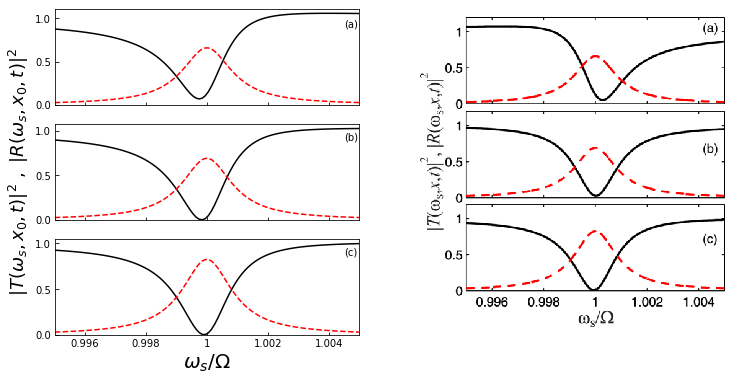

In [21]:
plt.figure(figsize=(12,6))

#繪製圖(a)
plt.subplot(321)
plt.text(1.0045*Omega,0.9,'(a)')
plt.plot(omega_s,abs(Transmission_o_x1_t)**2,'k',omega_s,abs(Reflection_o_x1_t)**2,'r--')
plt.xlim(0.995*Omega,1.005*Omega)
plt.ylim(0,)
plt.xticks([0.996*Omega,0.998*Omega,Omega,1.002*Omega,1.004*Omega],[' ',' ',' ',' ',' '])
plt.tick_params(direction='in')

#繪製圖(b)
plt.subplot(323)
plt.text(1.0045*Omega,0.9,'(b)')
plt.plot(omega_s,abs(Transmission_o_x2_t)**2,'k',omega_s,abs(Reflection_o_x2_t)**2,'r--')
plt.xlim(0.995*Omega,1.005*Omega)
plt.ylim(0,)
plt.xticks([0.996*Omega,0.998*Omega,Omega,1.002*Omega,1.004*Omega],[' ',' ',' ',' ',' '])
plt.tick_params(direction='in')
plt.ylabel('$|T(\omega_s,x_0,t)|^2\ ,\ |R(\omega_s,x_0,t)|^2$',fontsize=18)

#繪製圖(c)
plt.subplot(325)
plt.text(1.0045*Omega,0.87,'(c)')
plt.plot(omega_s,abs(Transmission_o_x3_t)**2,'k',omega_s,abs(Reflection_o_x3_t)**2,'r--')
plt.xlim(0.995*Omega,1.005*Omega)
plt.ylim(0,)
plt.xticks([0.996*Omega,0.998*Omega,Omega,1.002*Omega,1.004*Omega],[0.996,0.998,1,1.002,1.004])
plt.tick_params(direction='in')
plt.xlabel('$\omega_s/\Omega$',fontsize=20)

# Show images from paper
response = requests.get("https://journals.aps.org/pra/article/10.1103/PhysRevA.107.013519/figures/5/medium")
img = Image.open(BytesIO(response.content))
fig5 = img.crop((0, 0, 492, 500))
plt.subplot2grid((3,2), (0, 1), rowspan=3, colspan=1)
plt.imshow(fig5);
plt.axis('off');

<div align='center'>  Fig.7 the scattered field at large time, simulation(left), paper(right) </div>

&emsp;&emsp;The dependence of the transmittance (43) (solid black line) and reflectance (44) (dashed red line) on the photon frequency for different distances of the field point from the qubit: (a) x = 1 mm, (b) x = 5 mm, and (c) x = 10 mm.  
&emsp;&emsp;Interestingly, our simulation results (left) are exactly the opposite of the results in the paper (right).  
&emsp;&emsp;We see that the transmitted signal at resonance $(\omega_s = \Omega)$ is practically zero, while the amplitude of the reflected signal at resonance is appreciably smaller than unity. It can be attributed to the interference between two terms in equation(44).
&emsp;&emsp;Next, we will analyze this interference phenomenon in detail.

## Simulation 4: Interference phenomenon at resonance
#### &emsp; The sum of transmittance and reflectance is significantly less than one at the resonance point, which is a result of the interference phenomenon.
&emsp; From (44) we can write the squared modulus of the reflected field as $|R(\omega_s, x,t)|^2 = |R(\omega_s)|^2|(1 + z)|^2$, where z is the term in the brackets in (44). The influence of z on the reflected field at 1-mm distance from the qubit is shown below.

$ 
R(\omega_s,x,t)=R(\omega_s)e^{-i\frac{\omega_s}{v_g}(x+v_gt)}$   
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;
$+\frac{R(\omega_s)}{2\pi}$ $e^{-i\frac {\omega_s}{v_g}(x+v_gt)}[ici(\omega_{s}\frac{|x|}{v_g})+si(\omega_s\frac{|x|}{v_g})]$  
$Eq(44)$  
&emsp; &emsp; &emsp; &emsp; $x<0$ &emsp; $x+v_gt>0$  
$
|R(\omega_s,x,t)|^2 = |R(\omega_s)|^2|(1+z)|^2
$  
$z=\frac {1}{2\pi}[ici(\omega_{s}\frac{|x|}{v_g})+si(\omega_s\frac{|x|}{v_g})]$

In [22]:
t = 10**(-9) #1ns 自訂
x = -0.001 #1mm
o_width = 100
omega_sa = 0.995*Omega
omega_sb = 1.005*Omega
omega_s = np.linspace(omega_sa, omega_sb, o_width)

In [23]:
# 初始化一个用于存储结果的一维数组
Reflection_o_x_t = np.array([0+0j]*o_width)
Reflection_omega_s = np.array([0+0j]*o_width)
CI = np.array([0+0j]*o_width)
SI = np.array([0+0j]*o_width)
z = np.array([0+0j]*o_width)
R1 = np.array([0+0j]*o_width)
R2 = np.array([0+0j]*o_width)
R3 = np.array([0+0j]*o_width)

In [24]:
# directly compute with ci,si 
# 公式44 #
for i in range(len(omega_s)):
    Transmission_omega_s = (omega_s[i]-Omega)/(omega_s[i]-Omega+1j*Gamma/2)
    Reflection_omega_s[i] = -1j*Gamma/2/(omega_s[i]-Omega+1j*Gamma/2)
    EX = x+velocity_g*t
    CI[i] = ci = sc.sici(omega_s[i]*abs(x)/velocity_g)[1] 
    SI[i] = si = sc.sici(omega_s[i]*abs(x)/velocity_g)[0] - math.pi/2
    # Reflection_o_x_t
    R1[i] = Reflection_omega_s[i]*math.e**(-1j*(omega_s[i]/velocity_g)*EX)
    R2[i] = Reflection_omega_s[i]/2/math.pi*math.e**(-1j*omega_s[i]/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o_x_t[i] = R1[i] + R2[i] * R3[i] 
    z[i] = R3[i]/(2*math.pi)
    if x >= 0 :
        print('x>=0')
        break
    if EX <= 0 :
        print('x+velocity_g*t <= 0')
        break

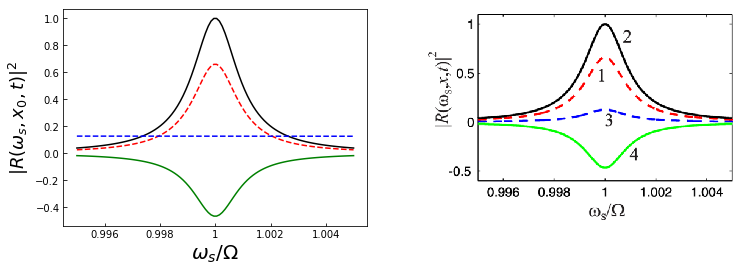

In [25]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(omega_s,abs(Reflection_o_x_t)**2,'r--')
plt.plot(omega_s,abs(Reflection_omega_s)**2,'k-')
plt.plot(omega_s,abs(z)**2,'b--')
plt.plot(omega_s,2*abs(Reflection_omega_s)**2*np.real(z),'g-')
plt.xticks([0.996*Omega,0.998*Omega,Omega,1.002*Omega,1.004*Omega],[0.996,0.998,1,1.002,1.004])
plt.tick_params(direction='in')
plt.xlabel('$\omega_s/\Omega$',fontsize=20)
plt.ylabel('$|R(\omega_s,x_0,t)|^2$',fontsize=18)


# Show images from paper
response = requests.get("https://journals.aps.org/pra/article/10.1103/PhysRevA.107.013519/figures/6/medium")
img = Image.open(BytesIO(response.content))
fig6 = img.crop((0, 0, 500, 338))
plt.subplot(122)
plt.imshow(fig6);
plt.axis('off');

<div align='center'>  Fig.8 the interference phenomenon at resonance, simulation(left), paper(right) </div>

&ensp;&ensp; The influence of the interference on the reflectance (44) at 1-mm distance from the qubit. Dashed red line, labeled 1, the reflectance $|R(\omega_s, x,t)|^2$; solid black line, labeled 2, the reflectance
$|R(\omega_s)|^2$ in the absence of interference; dashed blue line, labeled
3, the term $|z|^2$; solid green line, labeled 4, the interference term
$2|R(\omega_s)|^2Re(z)$.---from reference

&ensp;&ensp;It can be observed that in our simulation results (left), the curve for line 3 remains unchanged, which is a problem that is currently being worked on to resolve.

## Simulation 5: Interference phenomenon at off-resonance
#### &emsp; At off-resonant points, interference simultaneously affects both the transmission field and the reflection field.
&emsp; Simulate the variation in the intensity of the transmission field and reflection field with respect to position at different incident light frequencies using equations (43) and (44).

In [26]:
x0 = 0.01
xe = 1.7*wavelength
x_width = 50
xt = np.linspace(x0, xe, x_width)
xr = np.linspace(-x0, -xe, x_width)
omega_s1 = Omega              #photon frequency
omega_s2 = Omega + 0.5*Gamma
omega_s3 = Omega + 1.0*Gamma
omega_s4 = Omega + 1.5*Gamma

In [27]:
# 初始化一个用于存储结果的一维数组
Transmission_o1_x_t = np.array([0+0j]*x_width)
Transmission_o2_x_t = np.array([0+0j]*x_width)
Transmission_o3_x_t = np.array([0+0j]*x_width)
Transmission_o4_x_t = np.array([0+0j]*x_width)
T0 = np.array([0+0j]*x_width)
T1 = np.array([0+0j]*x_width)
T2 = np.array([0+0j]*x_width)
T3 = np.array([0+0j]*x_width)

# 初始化一个用于存储结果的一维数组
Reflection_o1_x_t = np.array([0+0j]*x_width)
Reflection_o2_x_t = np.array([0+0j]*x_width)
Reflection_o3_x_t = np.array([0+0j]*x_width)
Reflection_o4_x_t = np.array([0+0j]*x_width)
R0 = np.array([0+0j]*x_width)
R1 = np.array([0+0j]*x_width)
R2 = np.array([0+0j]*x_width)
R3 = np.array([0+0j]*x_width)

In [28]:
# omega_s1
# 公式43 #
for i in range(x_width):
    Transmission_omega_s = (omega_s1-Omega)/(omega_s1-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s1-Omega+1j*Gamma/2)
    EX = xt[i]-velocity_g*t
    si = sc.sici(omega_s1*xt[i]/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s1*xt[i]/velocity_g)[1]
    # Transmission_o1_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s1/velocity_g*EX)
    T2[i] = -1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*omega_s1/velocity_g*EX)
    T3[i] = 1j*ci+si          
    Transmission_o1_x_t[i] = T1[i] + T2[i] * T3[i]

    if xt[i] <= 0 :
        print('xt[i] <=0')
        print('i = ',i)
        break
    if EX >= 0 :
        print('xt[i]-velocity_g*t >= 0')
        print('i = ',i)
        break
        
# omega_s2
# 公式43 #
for i in range(x_width):
    Transmission_omega_s = (omega_s2-Omega)/(omega_s2-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s2-Omega+1j*Gamma/2)
    EX = xt[i]-velocity_g*t
    si = sc.sici(omega_s1*xt[i]/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s1*xt[i]/velocity_g)[1]    
    # Transmission_o2_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s2/velocity_g*EX)
    T2[i] = -1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*omega_s2/velocity_g*EX)
    T3[i] = 1j*ci+si          
    Transmission_o2_x_t[i] = T1[i] + T2[i] * T3[i]

    if xt[i] <= 0 :
        print('xt[i] <=0')
        print('i = ',i)
        break
    if EX >= 0 :
        print('xt[i]-velocity_g*t >= 0')
        print('i = ',i)
        break
        
# omega_s3
# 公式43 #
for i in range(x_width):
    Transmission_omega_s = (omega_s3-Omega)/(omega_s3-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s3-Omega+1j*Gamma/2)
    EX = xt[i]-velocity_g*t
    si = sc.sici(omega_s1*xt[i]/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s1*xt[i]/velocity_g)[1]  
    # Transmission_o3_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s3/velocity_g*EX)
    T2[i] = -1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*omega_s3/velocity_g*EX)
    T3[i] = 1j*ci+si       
    Transmission_o3_x_t[i] = T1[i] + T2[i] * T3[i]

    if xt[i] <= 0 :
        print('xt[i] <=0')
        print('i = ',i)
        break
    if EX >= 0 :
        print('xt[i]-velocity_g*t >= 0')
        print('i = ',i)
        break
        
# omega_s4
# 公式43 #
for i in range(x_width):
    Transmission_omega_s = (omega_s4-Omega)/(omega_s4-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s4-Omega+1j*Gamma/2)
    EX = xt[i]-velocity_g*t
    si = sc.sici(omega_s1*xt[i]/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s1*xt[i]/velocity_g)[1]  
    # Transmission_o4_x_t
    T1[i] = Transmission_omega_s*math.e**(1j*omega_s4/velocity_g*EX)
    T2[i] = -1j*Reflection_omega_s/(2*math.pi)*math.e**(1j*omega_s4/velocity_g*EX)
    T3[i] = 1j*ci+si       
    Transmission_o4_x_t[i] = T1[i] + T2[i] * T3[i]

    if xt[i] <= 0 :
        print('xt[i] <=0')
        print('i = ',i)
        break
    if EX >= 0 :
        print('xt[i]-velocity_g*t >= 0')
        print('i = ',i)
        break

In [29]:
# omega_s1
# 公式44 #
for i in range(x_width):
    Transmission_omega_s = (omega_s1-Omega)/(omega_s1-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s1-Omega+1j*Gamma/2)
    EX = xr[i]+velocity_g*t
    si = sc.sici(omega_s1*abs(xr[i])/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s1*abs(xr[i])/velocity_g)[1]
    # Reflection_o_x1_t            
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s1/velocity_g)*EX)
    R2[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s1/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o1_x_t[i] = R1[i] + R2[i] * R3[i] 
    if xr[i] >= 0 :
        print('xr>=0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t <= 0')
        print(i)
        break
        
# omega_s2
# 公式44 #
for i in range(x_width):
    Transmission_omega_s = (omega_s2-Omega)/(omega_s2-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s2-Omega+1j*Gamma/2)
    EX = xr[i]+velocity_g*t
    si = sc.sici(omega_s2*abs(xr[i])/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s2*abs(xr[i])/velocity_g)[1]
    # Reflection_o_x1_t            
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s2/velocity_g)*EX)
    R2[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s2/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o2_x_t[i] = R1[i] + R2[i] * R3[i] 
    if xr[i] >= 0 :
        print('xr>=0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t <= 0')
        print(i)
        break
        
# omega_s3
# 公式44 #
for i in range(x_width):
    Transmission_omega_s = (omega_s3-Omega)/(omega_s3-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s3-Omega+1j*Gamma/2)
    EX = xr[i]+velocity_g*t
    si = sc.sici(omega_s3*abs(xr[i])/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s3*abs(xr[i])/velocity_g)[1]
    # Reflection_o_x1_t            
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s3/velocity_g)*EX)
    R2[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s3/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o3_x_t[i] = R1[i] + R2[i] * R3[i] 
    if xr[i] >= 0 :
        print('xr>=0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t <= 0')
        print(i)
        break
        
# omega_s4
# 公式44 #
for i in range(x_width):
    Transmission_omega_s = (omega_s4-Omega)/(omega_s4-Omega+1j*Gamma/2)
    Reflection_omega_s = -1j*Gamma/2/(omega_s4-Omega+1j*Gamma/2)
    EX = xr[i]+velocity_g*t
    si = sc.sici(omega_s4*abs(xr[i])/velocity_g)[0] - math.pi/2
    ci = sc.sici(omega_s4*abs(xr[i])/velocity_g)[1]
    # Reflection_o_x1_t            
    R1[i] = Reflection_omega_s*math.e**(-1j*(omega_s4/velocity_g)*EX)
    R2[i] = Reflection_omega_s/2/math.pi*math.e**(-1j*omega_s4/velocity_g*EX)
    R3[i] = 1j*ci+si
    Reflection_o4_x_t[i] = R1[i] + R2[i] * R3[i] 
    if xr[i] >= 0 :
        print('xr>=0')
        break
    if EX <= 0 :
        print('xr+velocity_g*t <= 0')
        print(i)
        break

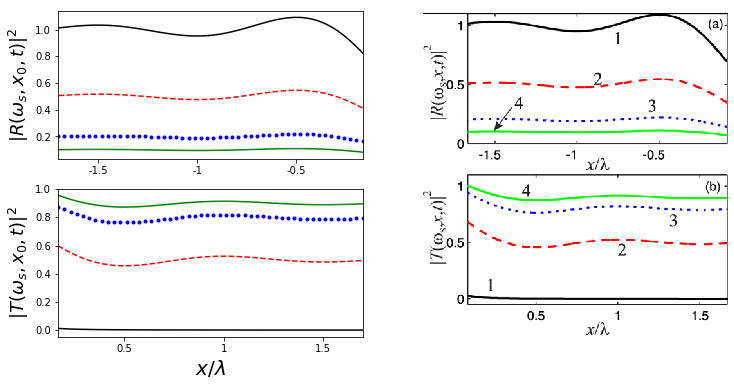

In [30]:
plt.figure(figsize=(12,6))
plt.subplot(223)
plt.plot(xt,abs(Transmission_o1_x_t)**2,'k-')
plt.plot(xt,abs(Transmission_o2_x_t)**2,'r--')
plt.plot(xt,abs(Transmission_o3_x_t)**2,'b.')
plt.plot(xt,abs(Transmission_o4_x_t)**2,'g-')
plt.xlim(x0,xe)
plt.xticks([0.5*wavelength,wavelength,1.5*wavelength],[0.5,1,1.5])
plt.xlabel('$x/\lambda$',fontsize=20)
plt.ylabel('$|T(\omega_s,x_0,t)|^2$',fontsize=18)

plt.subplot(221)
plt.plot(xr,abs(Reflection_o1_x_t)**2,'k-')
plt.plot(xr,abs(Reflection_o2_x_t)**2,'r--')
plt.plot(xr,abs(Reflection_o3_x_t)**2,'b.')
plt.plot(xr,abs(Reflection_o4_x_t)**2,'g-')
plt.xlim(-xe,-x0)
plt.xticks([-1.5*wavelength,-wavelength,-0.5*wavelength],[-1.5,-1,-0.5])
plt.ylabel('$|R(\omega_s,x_0,t)|^2$',fontsize=18)

# Show images from paper
response = requests.get("https://journals.aps.org/pra/article/10.1103/PhysRevA.107.013519/figures/7/medium")
img = Image.open(BytesIO(response.content))
fig7 = img.crop((0, -1, 474, 500))
plt.subplot2grid((2,2), (0, 1), rowspan=2, colspan=1)
plt.imshow(fig7);
plt.axis('off');

<div align='center'>  Fig.9 the interference phenomenon at off-resonance, simulation(left), paper(right) </div>

&emsp;&emsp;Spatial dependence of (a) reflectance (44) and (b) transmittance (43) for off-resonant conditions.  
&emsp;&emsp;Solid black line (labeled 1), $\omega_s = \Omega $; dashed red line (labeled 2), $\omega_s = \Omega + 0.5\Gamma$; dotted blue line (labeled 3), $\omega_s = \Omega + \Gamma$; solid green line (labeled 4), $\omega_s = \Omega + 1.5\Gamma$.---from reference

&emsp;&emsp;It can be seen that our simulation results (left) match the results in the paper (right). In both cases, the reflection field exhibits values greater than one at resonance, and as the incident light deviates from the resonance frequency, the reflection field gradually decreases while the transmission field gradually increases.

## Summary
&emsp;&emsp;In summary, we have successfully simulated most of the results based on the reference paper, although there are some discrepancies that are currently being addressed. Throughout the simulation process, I gained a deeper understanding of the interaction between individual photons and quantum states. I also became more proficient in using JupyterLab notebooks and Python for research simulations. With the guidance of my professor, we identified some discrepancies in the definitions of certain functions in the paper compared to Python libraries, which initially posed challenges but provided valuable experience.

&emsp;&emsp;In future, we may going to continue researching the mutual interactions between multi-photons and a qubit, bringing us closer to practical applications in optical semiconductor devices.